In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Parameters

In [2]:
SPLIT_TEST_SIZE    = 0.2
SPLIT_RANDOM_STATE = 17

# Loading the Dataset

In [3]:
def load_data():
    data_set  = pd.read_csv('data/flight_delays_data.csv')

    return data_set

def preprocess_data(data_set):
    # alter first column values from c-1 to 1, c-2 to 2, c-3 to 3
    data_set['Month'] = data_set['Month'].apply(lambda x: int(x.split('-')[1]))
    data_set['DayofMonth'] = data_set['DayofMonth'].apply(lambda x: int(x.split('-')[1]))
    data_set['DayOfWeek'] = data_set['DayOfWeek'].apply(lambda x: int(x.split('-')[1]))

    # encode the categorical data using LabelEncoder
    le = LabelEncoder()
    data_set['UniqueCarrier'] = le.fit_transform(data_set['UniqueCarrier'])
    data_set['Origin'] = le.fit_transform(data_set['Origin'])
    data_set['Dest'] = le.fit_transform(data_set['Dest'])

    data_set = numerical_label(data_set)

    return data_set

def numerical_label(data_set):
    data_set['dep_delayed_15min'] = data_set['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)

    return data_set

data_set = load_data()
data_set = preprocess_data(data_set)
data_set.head()

Month  DayofMonth  DayOfWeek  DepTime  UniqueCarrier  Origin  Dest  \
0      8          21          7     1934              0      18    78   
1      4          20          3     1548             18     217   171   
2      9           2          5     1422             20     228    59   
3     11          25          6     1015             15      78   175   
4     10           7          6     1828             19     174   199   

   Distance  dep_delayed_15min  
0       732                  0  
1       834                  0  
2       416                  0  
3       872                  0  
4       423                  1

# EDA (Exploratory Data Analysis)

## General Info

In [4]:
print(data_set.describe())
print(data_set.info())

# number of flights delayed and not delayed
print("\nNumber of flights delayed (1) and not delayed (0):")
flight_delay_counts = data_set['dep_delayed_15min'].value_counts()
print(flight_delay_counts)
print("Percentage of flights delayed: ", (flight_delay_counts[1]/(flight_delay_counts[0] + flight_delay_counts[1]))*100)

               Month     DayofMonth     DayOfWeek        DepTime  \
count  100000.000000  100000.000000  100000.00000  100000.000000   
mean        6.537640      15.703850       3.95183    1341.523880   
std         3.413447       8.793931       1.99164     476.378445   
min         1.000000       1.000000       1.00000       1.000000   
25%         4.000000       8.000000       2.00000     931.000000   
50%         7.000000      16.000000       4.00000    1330.000000   
75%         9.000000      23.000000       6.00000    1733.000000   
max        12.000000      31.000000       7.00000    2534.000000   

       UniqueCarrier        Origin           Dest      Distance  \
count  100000.000000  100000.00000  100000.000000  100000.00000   
mean       12.045040     142.37781     141.041110     729.39716   
std         6.566272      76.89900      76.783888     574.61686   
min         0.000000       0.00000       0.000000      30.00000   
25%         6.000000      78.00000      77.000000   

According to the percentage of the target classes, no-learning would result in %80 accuracy with the majority class prediction method. So we need to achieve higher than 80.

## Correlation Matrix

                      Month  DayofMonth  DayOfWeek   DepTime  UniqueCarrier  \
Month              1.000000    0.007106   0.004717 -0.001544       0.008111   
DayofMonth         0.007106    1.000000  -0.015537  0.001116       0.002717   
DayOfWeek          0.004717   -0.015537   1.000000  0.009392      -0.010054   
DepTime           -0.001544    0.001116   0.009392  1.000000       0.012335   
UniqueCarrier      0.008111    0.002717  -0.010054  0.012335       1.000000   
Origin             0.002504    0.000357   0.002445 -0.039127       0.075862   
Dest               0.008895   -0.000970  -0.000576  0.023091       0.074313   
Distance           0.006853    0.001510   0.011937 -0.020681      -0.232401   
dep_delayed_15min  0.016998    0.025842   0.010439  0.243819      -0.001706   

                     Origin      Dest  Distance  dep_delayed_15min  
Month              0.002504  0.008895  0.006853           0.016998  
DayofMonth         0.000357 -0.000970  0.001510           0.025842  
Da

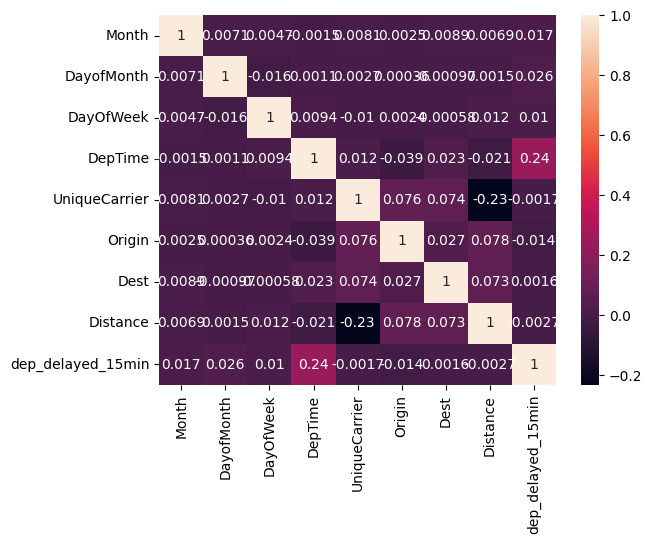

In [5]:
corr = data_set.corr()
print(corr)
sns.heatmap(corr, annot=True)
plt.show()

## Pairplot

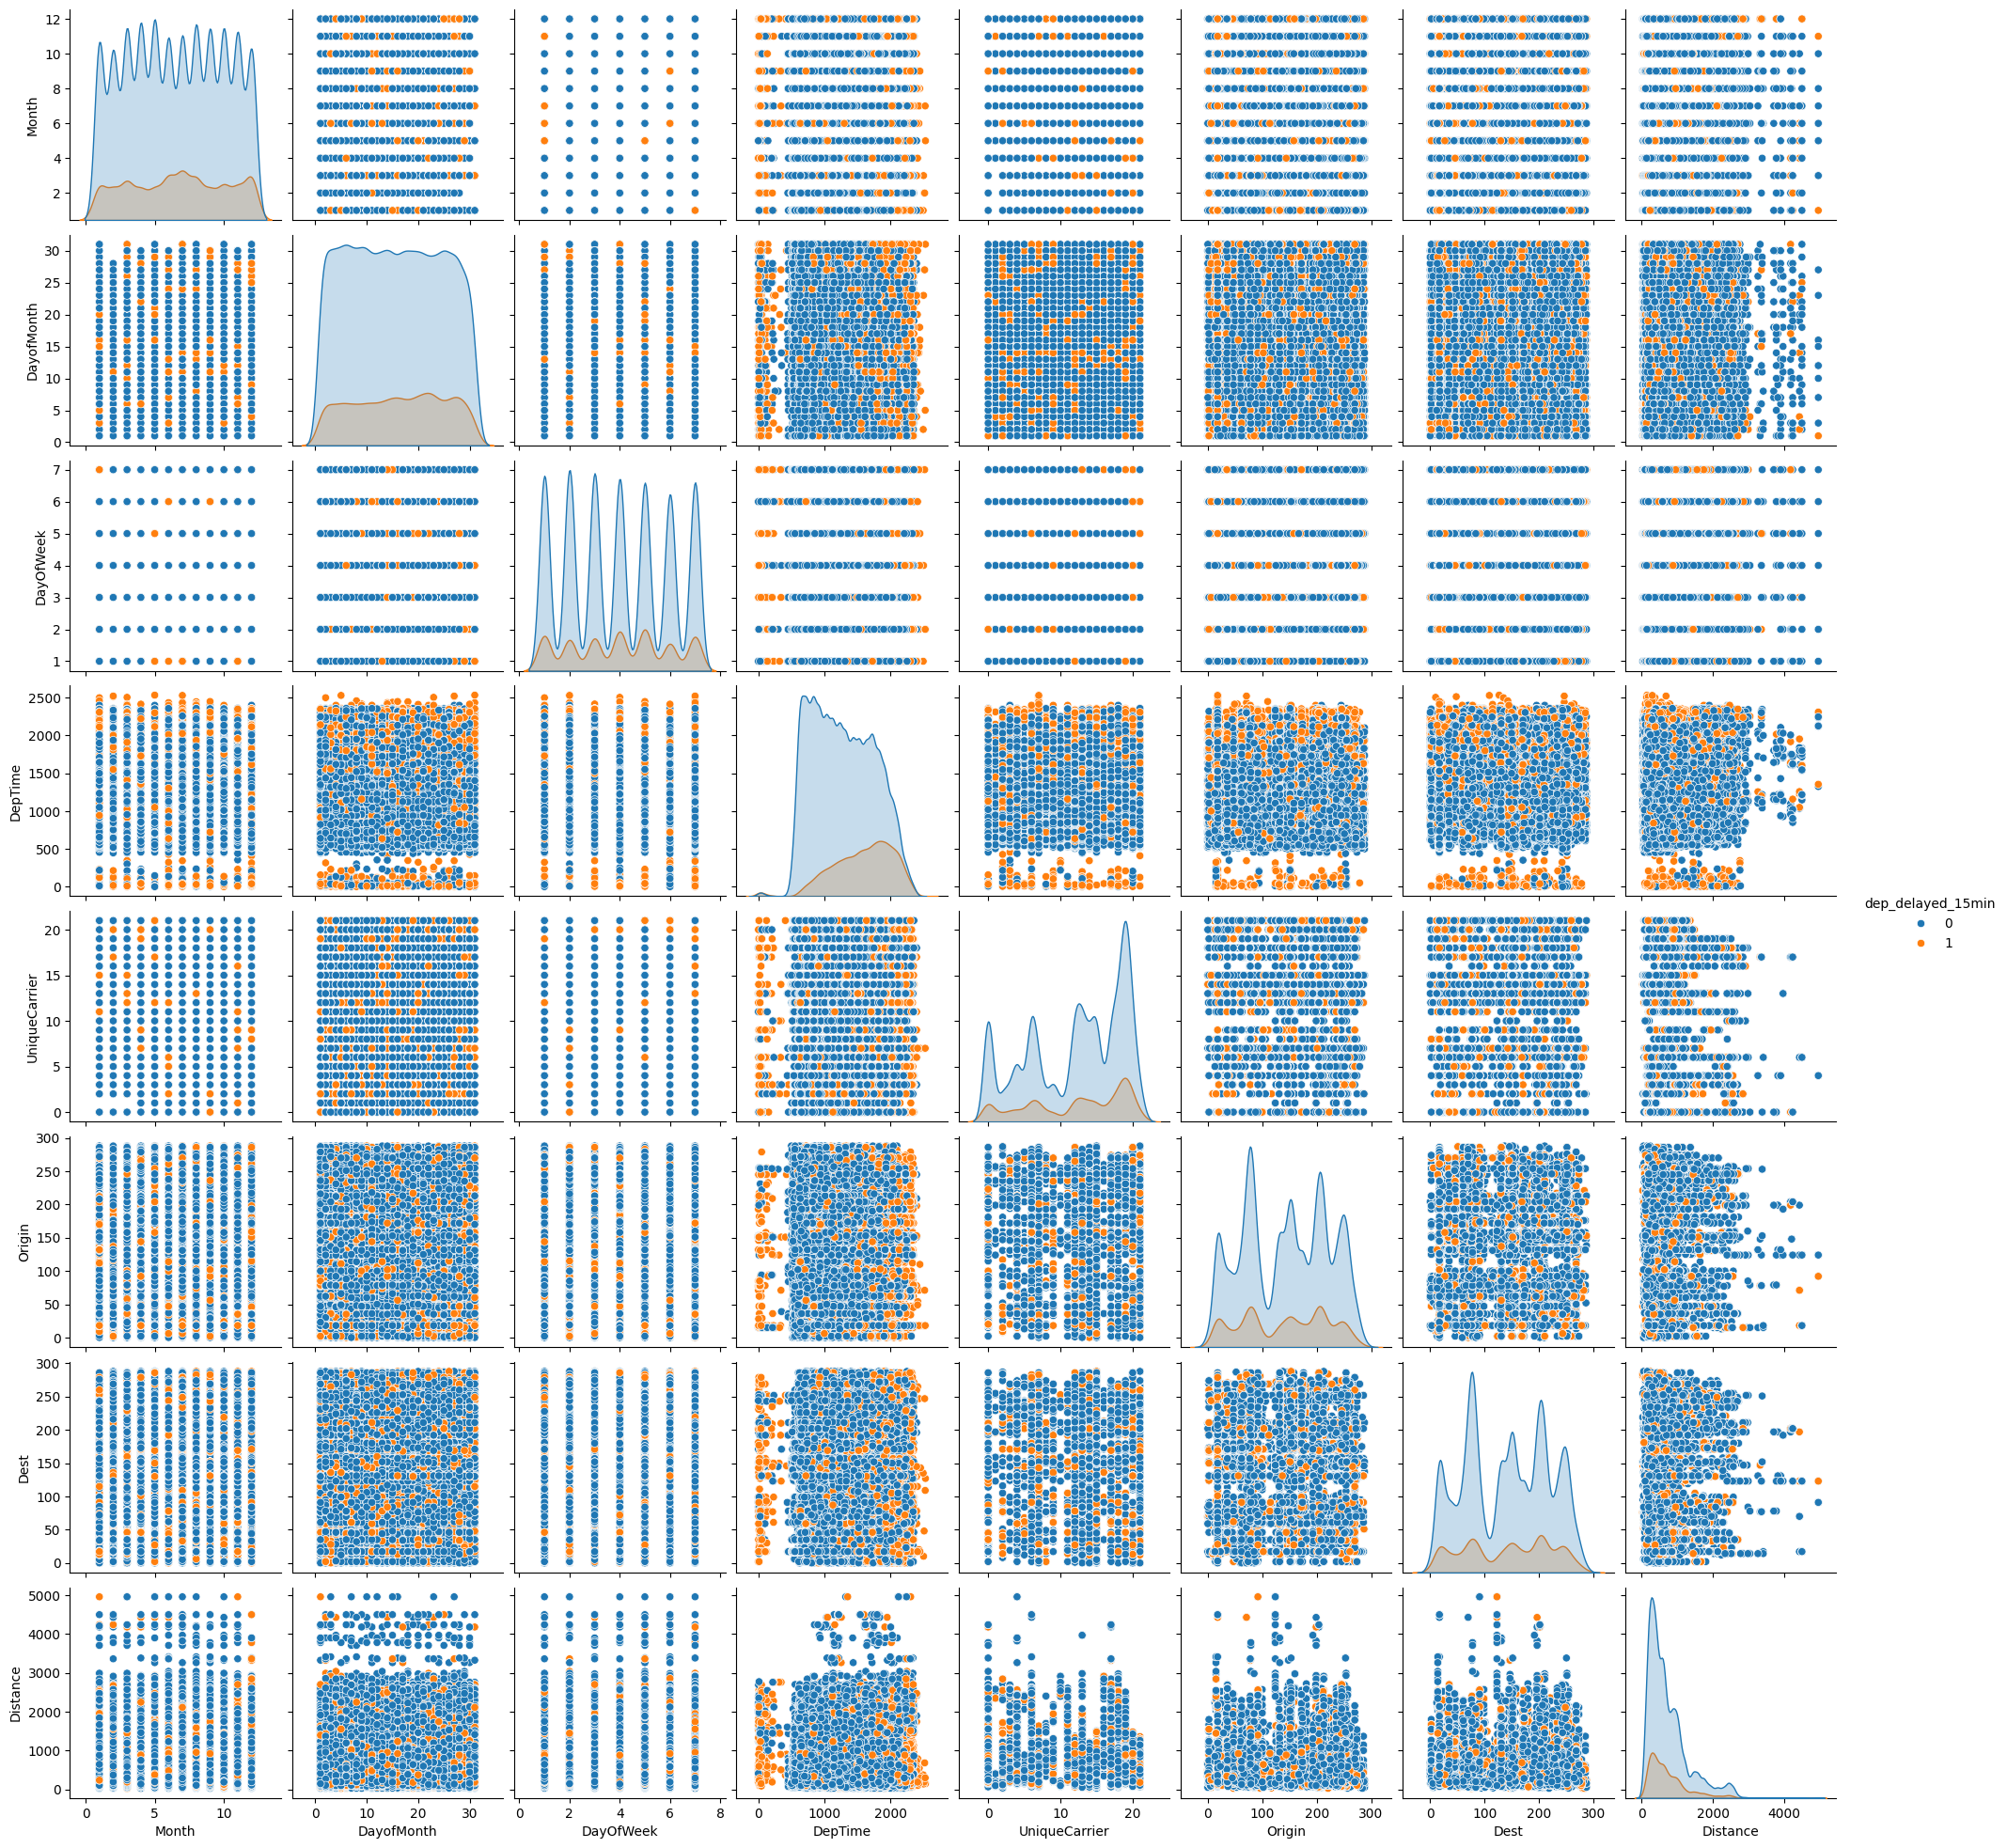

In [6]:
sns.pairplot(data_set, hue='dep_delayed_15min')
plt.show()

By having a quick look on the pairplot of the dataset, we can see that DepTime feature is a nice feature for predicting. Other than that, some combinations of the features might also work for predictions. We will try using all features and then only the DepTime feature and compare the results.

# Training Models

Before training, we need to separate the labels from features and also split the data to train and test sets. Selecting 80/20 ratio for splitting.

In [7]:
y = data_set['dep_delayed_15min']
x = data_set.drop('dep_delayed_15min', axis=1)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=SPLIT_TEST_SIZE, random_state=SPLIT_RANDOM_STATE, shuffle=True)

Import necessary libraries:

In [8]:
from lib.dt import fit_decision_tree
from lib.rf import fit_random_forest
from lib.svm import fit_svm
from lib.dnn import fit_dnn

2024-08-09 14:46:24.391212: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 14:46:24.406333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 14:46:24.421549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 14:46:24.428211: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 14:46:24.437447: I tensorflow/core/platform/cpu_feature_guar

## Decision Tree Classifiers

In [9]:
dt_list = []
for i in range(1, 9):
    depth = i*8
    print("\nDecision Tree with max depth: ", depth)
    dt = fit_decision_tree(x_train, y_train, depth)
    dt_list.append([dt, depth])


Decision Tree with max depth:  8

Decision Tree with max depth:  16

Decision Tree with max depth:  24

Decision Tree with max depth:  32

Decision Tree with max depth:  40

Decision Tree with max depth:  48

Decision Tree with max depth:  56

Decision Tree with max depth:  64


## Random Forest Classifiers

In [10]:
rf_list = []
for i in range(1, x_train.shape[1]-1):
    max_features = i
    print("\nRandom Forest with max features: ", max_features)
    rf = fit_random_forest(x_train, y_train, max_features)
    rf_list.append([rf, max_features])


Random Forest with max features:  1

Random Forest with max features:  2

Random Forest with max features:  3

Random Forest with max features:  4

Random Forest with max features:  5

Random Forest with max features:  6


## SVM

In [11]:
svm = fit_svm(x_train, y_train)

## DNN

In [13]:
dnn = fit_dnn(x_train, y_train, num_epochs=50, batch_size=32)

Epoch 1/50


I0000 00:00:1723204286.909191   30334 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723204286.949302   30334 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723204286.950605   30334 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723204286.952813   30334 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

 143/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2964 - loss: 13.5787

I0000 00:00:1723204290.561817   30775 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 928us/step - accuracy: 0.6758 - loss: 2.1409
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 938us/step - accuracy: 0.8088 - loss: 0.4906
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 841us/step - accuracy: 0.8073 - loss: 0.4828
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 897us/step - accuracy: 0.8067 - loss: 0.4778
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 801us/step - accuracy: 0.8083 - loss: 0.4713
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 838us/step - accuracy: 0.8086 - loss: 0.4691
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 763us/step - accuracy: 0.8101 - loss: 0.4653
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 846us/step - accuracy: 0.8089 - loss: 0.4674
Epoch 9/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 746us/step - accuracy: 0.8104 - loss: 0.4649
Epoch 10/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 819us/step - accuracy: 0.8096 - loss: 0.4649
Epoch 11/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 756us/step - accuracy: 0.8085 - loss: 0.4651
Epoch 12/50
2500/25

# Metrics

Import necessary libraries:

In [14]:
from sklearn.metrics import classification_report

## Decision Tree Classifiers

### Test Set Metrics

In [15]:
for tuple in dt_list:
    dt = tuple[0]
    max_depth = tuple[1]

    print("\nDecision Tree with max depth: ", max_depth)
    y_pred = dt.predict(x_test)
    print(classification_report(y_test, y_pred))


Decision Tree with max depth:  8
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     16211
           1       0.55      0.08      0.13      3789

    accuracy                           0.81     20000
   macro avg       0.68      0.53      0.51     20000
weighted avg       0.77      0.81      0.75     20000


Decision Tree with max depth:  16
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     16211
           1       0.37      0.22      0.28      3789

    accuracy                           0.78     20000
   macro avg       0.60      0.57      0.57     20000
weighted avg       0.75      0.78      0.76     20000


Decision Tree with max depth:  24
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     16211
           1       0.31      0.31      0.31      3789

    accuracy                           0.74     20000
   macro avg       0.57 

### Train Set Metrics

In [16]:
for tuple in dt_list:
    dt = tuple[0]
    max_depth = tuple[1]

    print("\nDecision Tree with max depth: ", max_depth)
    y_pred = dt.predict(x_train)
    print(classification_report(y_train, y_pred))


Decision Tree with max depth:  8
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     64745
           1       0.68      0.09      0.17     15255

    accuracy                           0.82     80000
   macro avg       0.75      0.54      0.53     80000
weighted avg       0.79      0.82      0.76     80000


Decision Tree with max depth:  16
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     64745
           1       0.89      0.50      0.64     15255

    accuracy                           0.89     80000
   macro avg       0.89      0.74      0.79     80000
weighted avg       0.89      0.89      0.88     80000


Decision Tree with max depth:  24
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     64745
           1       0.99      0.93      0.96     15255

    accuracy                           0.99     80000
   macro avg       0.99 

## Random Forest Classifiers

### Test Set Metrics

In [17]:
for tuple in rf_list:
    rf = tuple[0]
    max_features = tuple[1]

    print("\nDecision Tree with max features: ", max_features)
    y_pred = rf.predict(x_test)
    print(classification_report(y_test, y_pred))


Decision Tree with max features:  1
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     16211
           1       0.62      0.08      0.14      3789

    accuracy                           0.82     20000
   macro avg       0.72      0.53      0.52     20000
weighted avg       0.78      0.82      0.75     20000


Decision Tree with max features:  2
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     16211
           1       0.63      0.11      0.19      3789

    accuracy                           0.82     20000
   macro avg       0.73      0.55      0.54     20000
weighted avg       0.79      0.82      0.76     20000


Decision Tree with max features:  3
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     16211
           1       0.64      0.13      0.21      3789

    accuracy                           0.82     20000
   macro avg     

### Train Set Metrics

In [18]:
for tuple in rf_list:
    rf = tuple[0]
    max_features = tuple[1]

    print("\nDecision Tree with with max features: ", max_features)
    y_pred = rf.predict(x_train)
    print(classification_report(y_train, y_pred))


Decision Tree with with max features:  1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64745
           1       1.00      1.00      1.00     15255

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000


Decision Tree with with max features:  2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64745
           1       1.00      1.00      1.00     15255

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000


Decision Tree with with max features:  3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64745
           1       1.00      1.00      1.00     15255

    accuracy                           1.00     80000
  

## SVM

### Test Set Metrics

In [19]:
y_pred = svm.predict(x_test)
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     16211
           1       1.00      0.00      0.00      3789

    accuracy                           0.81     20000
   macro avg       0.91      0.50      0.45     20000
weighted avg       0.85      0.81      0.73     20000



### Train Set Metrics

In [20]:
y_pred = svm.predict(x_test)
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     16211
           1       1.00      0.00      0.00      3789

    accuracy                           0.81     20000
   macro avg       0.91      0.50      0.45     20000
weighted avg       0.85      0.81      0.73     20000



## DNN

### Test Set Metrics

In [21]:
y_pred = dnn.predict(x_test)
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_test, y_pred, zero_division=1))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 439us/step
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     16211
           1       0.81      0.00      0.01      3789

    accuracy                           0.81     20000
   macro avg       0.81      0.50      0.45     20000
weighted avg       0.81      0.81      0.73     20000



### Train Set Metrics

In [22]:
y_pred = dnn.predict(x_train)
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_train, y_pred, zero_division=1))

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     64745
           1       0.95      0.00      0.01     15255

    accuracy                           0.81     80000
   macro avg       0.88      0.50      0.45     80000
weighted avg       0.84      0.81      0.73     80000



# Model Comparisons